# LAYER NORMALIZATION

In [1]:
import torch
import torch.nn as nn

In [2]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [3]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("mean:\n", mean)
print("variance:\n", var)

mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [4]:
out_norm = (out-mean)/torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("normalized layer outs:\n", out_norm)
print("mean:\n", mean)
print("variance:\n", var)

normalized layer outs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [5]:
torch.set_printoptions(sci_mode=False)

In [6]:
print("mean:\n", mean)
print("variance:\n", var)

mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [7]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps) #prevents division by zero  b
    return self.scale * norm_x + self.shift

In [8]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()
    self.eps = 1e-5

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

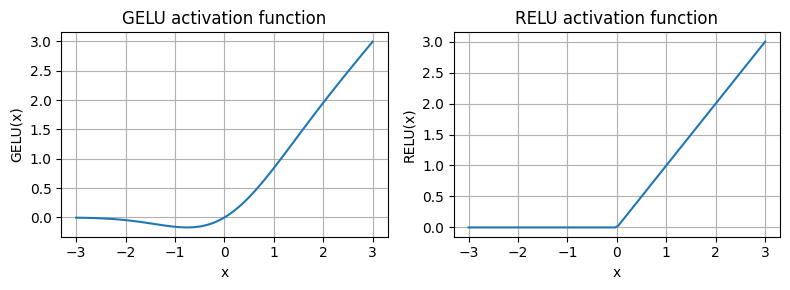

In [10]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

#sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize = (8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)


plt.tight_layout()
plt.show()

# FEED FORWARD

In [11]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,         # Size of the tokenizer vocabulary (number of unique tokens)
    "context_length": 1024,      # Max number of tokens the model can process in a single input (sequence length)
    "emb_dim": 768,              # Dimension of the token embeddings (also the hidden size of the model)
    "n_heads": 12,               # Number of attention heads in multi-head self-attention
    "n_layers": 12,              # Number of transformer blocks (depth of the model)
    "drop_rate": 0.1,            # Dropout rate used for regularization
    "qkv_bias": False            # Whether to include bias terms in the Q, K, V linear projections
}

In [12]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  #EXPANSION
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),  #CONTRACTION
    )

  def forward(self, x):
    return self.layers(x)


In [13]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [14]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [15]:
print(out)

tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1050,  ...,  0.1439,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0701,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)


# SHORTCUT CONNECTIONS

In [16]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
      for layer in self.layers:
        layer_output = layer(x)

        if self.use_shortcut and x.shape == layer_output.shape:
          x = x + layer_output
        else:
          x = layer_output

      return x


In [17]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

In [18]:
def print_gradients(model, x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)

  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")



In [19]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [20]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)

In [21]:
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


# CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

In [22]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,         # Size of the tokenizer vocabulary (number of unique tokens)
    "context_length": 1024,      # Max number of tokens the model can process in a single input (sequence length)
    "emb_dim": 768,              # Dimension of the token embeddings (also the hidden size of the model)
    "n_heads": 12,               # Number of attention heads in multi-head self-attention
    "n_layers": 12,              # Number of transformer blocks (depth of the model)
    "drop_rate": 0.1,            # Dropout rate used for regularization
    "qkv_bias": False            # Whether to include bias terms in the Q, K, V linear projections
}

THE BUILDING BLOCKS

In [23]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + self.eps) #prevents division by zero  b
    return self.scale * norm_x + self.shift

In [24]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()
    self.eps = 1e-5

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

In [25]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  #EXPANSION
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),  #CONTRACTION
    )

  def forward(self, x):
    return self.layers(x)


In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

Let us code the transformer block now

In [27]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.dropout_shortcut = nn.Dropout(cfg["drop_rate"])


  def forward(self, x):
    # shortcut connection for attention block
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.dropout_shortcut(x)
    x = x + shortcut


    # shortcut conenction for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.dropout_shortcut(x)
    x = x + shortcut

    return x


In [28]:
# pip install torchviz


In [29]:
# import torch
# from torchviz import make_dot


In [30]:
# cfg = {
#     "emb_dim": 64,
#     "context_length": 10,
#     "n_heads": 4,
#     "drop_rate": 0.1,
#     "qkv_bias": True
# }

# model = TransformerBlock(cfg)
# dummy_input = torch.randn(1, cfg["context_length"], cfg["emb_dim"])  # (batch, seq_len, dim)


In [31]:
# output = model(dummy_input)

# # Visualize the graph
# dot = make_dot(output, params=dict(model.named_parameters()))
# dot.format = "png"
# dot.render("transformer_block_graph", cleanup=True)  # saves as transformer_block_graph.png


In [32]:

# from IPython.display import Image
# Image(filename="transformer_block_graph.png")


In [33]:
# model1 = FeedForward(cfg)

In [34]:
# output1 = model1(dummy_input)

In [35]:
# dot1 = make_dot(output1, params=dict(model.named_parameters()))
# dot1.format = "png"
# dot1.render("transformer_block_graph1", cleanup=True)  # saves as transformer_block_graph.png

In [36]:

# from IPython.display import Image
# Image(filename="transformer_block_graph1.png")


# ENTIRE GPT MODEL ARCHITECTURE

In [37]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,         # Size of the tokenizer vocabulary (number of unique tokens)
    "context_length": 1024,      # Max number of tokens the model can process in a single input (sequence length)
    "emb_dim": 768,              # Dimension of the token embeddings (also the hidden size of the model)
    "n_heads": 12,               # Number of attention heads in multi-head self-attention
    "n_layers": 12,              # Number of transformer blocks (depth of the model)
    "drop_rate": 0.1,            # Dropout rate used for regularization
    "qkv_bias": False            # Whether to include bias terms in the Q, K, V linear projections
}

In [38]:
import torch
import torch.nn as nn

In [39]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__( )
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])


    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm = LayerNorm(cfg["emb_dim"])

    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )


  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))    #->creates a tensor([0,1,2,3]) and thu has an access of first four positions of the positonal embedding
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


In [40]:
input1 = torch.tensor([6109, 3626, 6100, 345])
input2 = torch.tensor([6109, 1110, 6622, 257])
batch = torch.stack((input1, input2), dim=0)

In [41]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("\Input_batch_size:\n", batch.shape)
print("\output batch_size:\n ", out.shape)

\Input_batch_size:
 torch.Size([2, 4])
\output batch_size:
  torch.Size([2, 4, 50257])


In [42]:
print("\Input_batch_size:\n", batch)
print("\output batch_size:\n ", out)

\Input_batch_size:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
\output batch_size:
  tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [43]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total no. of parameters in our model till now:",total_params)

Total no. of parameters in our model till now: 163009536


In [44]:
trainable_params_gpt2 = total_params-sum(p.numel() for p in model.out_head.parameters())
print(f"Total no. of parameters considering weight tying:",trainable_params_gpt2)

Total no. of parameters considering weight tying: 124412160


In [45]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024*1024)
print(f"total size of the model: {total_size_mb:.2f} MB")

total size of the model: 621.83 MB


# PREDICTING OUTPUT EMBEDDING USING THE LOGITS

In [46]:
from transformers import GPT2Tokenizer

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Print some token ID to token mappings
# for token_id in range(20):  # first 20 tokens
token_id = 257
token = tokenizer.decode([token_id])
bpe_token = tokenizer.convert_ids_to_tokens(token_id)
print(f"ID: {token_id:<3} | Token: '{token}' | BPE: {bpe_token}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

ID: 257 | Token: ' a' | BPE: Ġa


In [47]:
token_id = 2507
token = tokenizer.decode([token_id])
bpe_token = tokenizer.convert_ids_to_tokens(token_id)
print(f"ID: {token_id:<3} | Token: '{token}' | BPE: {bpe_token}")

ID: 2507 | Token: 'ude' | BPE: ude


In [48]:
token_id = 2746
token = tokenizer.decode([token_id])
bpe_token = tokenizer.convert_ids_to_tokens(token_id)
print(f"ID: {token_id:<3} | Token: '{token}' | BPE: {bpe_token}")

ID: 2746 | Token: ' model' | BPE: Ġmodel


In [49]:
token_id = 3492
token = tokenizer.decode([token_id])
bpe_token = tokenizer.convert_ids_to_tokens(token_id)
print(f"ID: {token_id:<3} | Token: '{token}' | BPE: {bpe_token}")

ID: 3492 | Token: ' ready' | BPE: Ġready


In [50]:
token_id = 13
token = tokenizer.decode([token_id])
bpe_token = tokenizer.convert_ids_to_tokens(token_id)
print(f"ID: {token_id:<3} | Token: '{token}' | BPE: {bpe_token}")

ID: 13  | Token: '.' | BPE: .


In [51]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  # idx -> (batch, n_tokens)
  for _ in range(max_new_tokens):

    # crop the current context if it ofc exceed the supported context size
    idx_cond = idx[:, -context_size: ]

    with torch.no_grad():
      logits = model(idx_cond)

    # (batch, num_tokens, vocab_size) -> (batch, vocab_size)
    # extract the last row
    logits = logits[:, -1, :]


    probas = torch.softmax(logits, dim=-1)


    idx_next =  torch.argmax(probas, dim=-1, keepdim=True)

    idx = torch.cat((idx, idx_next), dim=1)

  return idx

softmax is redundant here? -> additional intuitions

In [52]:
!pip3 install tiktoken


In [53]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


In [54]:
tokenizer = tiktoken.get_encoding("gpt2")

In [55]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded: [15496, 11, 314, 716]


In [56]:
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded tensor shape:", encoded_tensor.shape)

encoded tensor shape: torch.Size([1, 4])


In [57]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 6,
    context_size = GPT_CONFIG_124M["context_length"]
)
print(out)

tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])


In [58]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


# LECTURE-27(MEASURING THE LLM LOSS)

In [59]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,         # Size of the tokenizer vocabulary (number of unique tokens)
    "context_length": 256,      # Max number of tokens the model can process in a single input (sequence length)
    "emb_dim": 768,              # Dimension of the token embeddings (also the hidden size of the model)
    "n_heads": 12,               # Number of attention heads in multi-head self-attention
    "n_layers": 12,              # Number of transformer blocks (depth of the model)
    "drop_rate": 0.1,            # Dropout rate used for regularization
    "qkv_bias": False            # Whether to include bias terms in the Q, K, V linear projections
}

In [60]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  #dia=sable dropout during inference

In [65]:
def text_to_token_id(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
  flat = token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")


token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_id(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)


print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


CALCULATING THE TEXT GENERATION LOSS: CROSS ENTROPY AND PERPLEXITY

In [66]:
inputs = torch.tensor([[6833, 3626, 6100],    # ["every effort moves"]
                       [40,   1107,  588]])   # ["I really like"]

targets = torch.tensor([[3626, 6100, 345],    # [" effort moves you"]
                        [1107,  588, 11311]]) # ["really like chocolate"]


In [69]:
with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [70]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("token_ids:\n", token_ids)

token_ids:
 tensor([[[ 3558],
         [16031],
         [21177]],

        [[49906],
         [29669],
         [41751]]])


In [71]:
print(f"target batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

target batch 1:  effort moves you
outputs batch 1: ests saves Admir


In [72]:
print(f"target batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"outputs batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

target batch 2:  really like chocolate
outputs batch 2:  pressuring empoweredfaith


**CROSS ENTROPY LOSS**